# Capstone 2. Data cleaning & storytelling

July, 2018
***


**Objective:** As I mentioned in the proposal, the major goal of this capstone project is to help job seekers, especially those new graduates with not previous job experience, find their dream job based on their answers to our questionnaire. Because extensive web scrap is perhibited in those major job posting website such as Linkedin and indeed, I chose an job description data set from Kaggle.com. Data source: [kaggle dataset](https://www.kaggle.com/PromptCloudHQ/us-jobs-on-monstercom)

Questionnaire will cover those aspects:
- Industry 
- Location
- Culture

Each aspect need the user a number indicating the level of the importance.

And finally, we will do a matching between job descriptions and the answer of the questionnaire.
***
*For example: *

I may answer the questionnaire in this way:

- Industry = art; artificial intelligence. Weight = 40%
- Location = big cities; eastern coast. Weight = 20%
- Culture = innovation; open. Weight = 40%

And I hope to get job recommendations from this project.

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from time import sleep
import math
import seaborn as sns
from scipy.spatial import distance

import plotly as py
import plotly.figure_factory as ff
py.offline.init_notebook_mode(connected=True)

import nltk
from nltk.stem import PorterStemmer
import gensim
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')

# Section 1: The dataset

In [2]:
# import the dataset and see how it looks like
df = pd.read_csv('monster_com-job_sample 2.csv')

# some basic inforamtion
print('There are {:d} job decriptions in the dataset.'.format(df.shape[0]))
print('The jobs are located in those country: ', df.country_code.unique().item())
print('{:d} out of 22000 job descriptions are tagged with a salary'.format(22000-sum(df.salary.isnull())))

There are 22000 job decriptions in the dataset.
The jobs are located in those country:  US
3446 out of 22000 job descriptions are tagged with a salary


In [3]:
# drop columns that are not helpful for the following analysis
df = df.drop(df.columns[[0,1,2,3,4,7,10,11,12,13]],axis=1)
df.head()

,job_description,job_title,location,organization
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail


In this dataset, we kept those columns which would be useful in the following sections. 
 - The **job_description** and **job_title** will be used to match industry. 
 - **organization** will be used for finding the name of that company and the culture of it. 
 - **location**, will be used to calculate distance, as well as finding out if the job located at big or small city, with increasing or declining population and so on.

# Section 2: Location 

### Extract the location information: zip code, state, city
Notice that this dataset is not cleaned. The locations have different format so that we need to extract that information use some technology such as regular expression.


In [4]:
# extract zip code information from the location column
# extract state information from the location column
p = re.compile(r'(?<![A-Z])[A-Z]{2}(?![A-Z])')
for i, row in df.iterrows():
    # add the column zip code
    ls = []
    for char in row.location:
        if char.isdigit():
            ls.append(char)
    if len(ls) == 5:
        df.set_value(i,'zip_code', ''.join(ls))
    
    # add the column state
    str_location = row.location
   
    if len(str_location) < 100 and len(str_location) > 1:
        state = p.search(str_location)
        if state is not None:
            df.set_value(i, 'state', state.group())
            ls = str_location.split(',')
            df.set_value(i, 'city', ls[0])
df.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,NaN,NaN,NaN
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries,NaN,CA,Dixon
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail,NaN,PA,Camphill


### Dataset exploration 1: look at locations that have the biggest number of jobs

There are 19194 jobs that shows which City they located at.


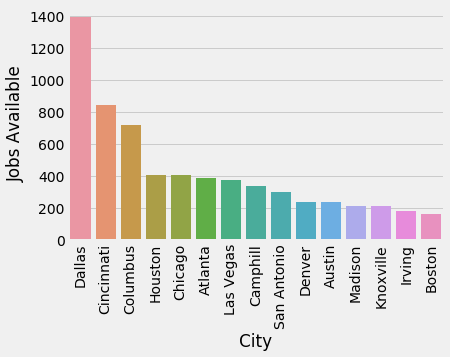

In [5]:
df_dropna = df[~df.state.isnull()]
print('There are %d jobs that shows which City they located at.' % len(df_dropna))

data = df_dropna.groupby('city').count().job_description.sort_values(ascending = False)[:15]
df_data = data.to_frame()
df_data['city'] = df_data.index
df_data.columns = ['Jobs Available', 'City']

g = sns.barplot(x='City', y='Jobs Available', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

There are 19194 jobs that shows which State they located at.


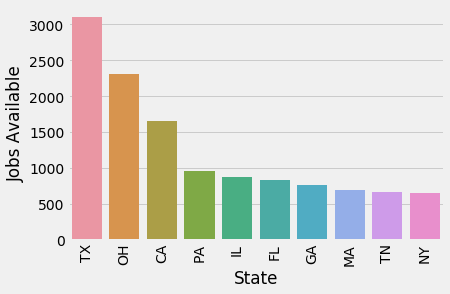

In [6]:
data = df_dropna.groupby('state').count().job_description.sort_values(ascending = False)[:10]
print('There are %d jobs that shows which State they located at.' % len(df_dropna))
df_data = data.to_frame()
df_data['State'] = df_data.index
df_data.columns = ['Jobs Available', 'State']

g = sns.barplot(x='State', y='Jobs Available', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Dataset exploration 2: save the DataFrame as excel and mapping the data in the USA map.
I first started with Tableau. I saved the data into an excel file and then use Tableau to open it and created an interactive plot of job scattering on an USA map. 

After my trial's version expired, I was looking for an free one with python to do the task, and I found [Plotly](https://plot.ly/python/county-choropleth/). When I make those plots, I got an error message of "unrecognized FIPS Vales". Then I reallized that Plotly take FIPS (The Federal Information Processing Standard) not zipcode. And FIPS is an area code that covers a much larger area than zipcode, which is actually more reasonable to use when we try to determine if an location is good or not for some one.

I convert zipcode to FIPS using the work I found: [zip2fips.json](https://github.com/bgruber/zip2fips). Thanks to the authors!

#### Export the dataset into an excel file, so that Teableau can read.
writer = pd.ExcelWriter('monster_zipcode.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

Here is what I got by using Teableau:
![Here is what I got by using Teableau](map.png)

In [17]:
df_dropna_zip = df[~df.zip_code.isnull()]
print('There are %d jobs that shows which zip_code they located at.' % len(df_dropna_zip))

# here we drop those job descriptions that I can't get the zipcode information from 
df_dropna_zip.head()

There are 12059 jobs that shows which zip_code they located at.


,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
7,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,"Austin, TX 73301",NaN,73301,TX,Austin
8,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,78746,TX,Austin
10,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville


In [12]:
# tranform the zip_code into fips code, so that Plotly can use.
dic_zip2fips = json.load(open('zip2fips.json'))

# add a column of FIPS
for index, row in df_dropna_zip.iterrows():
    zip_code = row.zip_code
    try:
        FIPS = dic_zip2fips[zip_code]
        df_dropna_zip.set_value(index, 'FIPS', FIPS)
    except:
        # set to '' for those zipcode we cannot get the FIPS value
        df_dropna_zip.set_value(index, 'FIPS', '')

# this panda series contains the number of jobs in each zip code
data = df_dropna_zip.groupby('FIPS').count().job_description.sort_values(ascending = False)
data[:5]

FIPS
48113    906
         850
39061    491
39049    449
17031    367
Name: job_description, dtype: int64

In [16]:
# Note: that we need to delete the second item. 
# Those are the collection of the zipcodes that could not find the FIPS code.
fips = data.index.tolist()
values = data.tolist()

# delet the row with ''
fips = fips[:1] + fips[2:]
values = values[:1] + values[2:]

# plot using plotly
fig = ff.create_choropleth(fips=fips, values=values)
py.offline.iplot(fig, filename='choropleth_full_usa')

/Users/yaqiongzhang/anaconda/lib/python3.6/site-packages/plotly/figure_factory/_county_choropleth.py:763: UserWarning:

Unrecognized FIPS Values

Whoops! It looks like you are trying to pass at least one FIPS value that is not in our shapefile of FIPS and data for the counties. Your choropleth will still show up but these counties cannot be shown.
Unrecognized FIPS are: [12025, 22915, 78000]



Note that there are 3 unrecognized FIPS. Those are due to changes made by the goverment.  For example: [(source)](https://www.ddorn.net/data/FIPS_County_Code_Changes.pdf) Forida, 1990s: Dade county changes name to Miami-Dade. FIPS code is changed from 12025 to 12086 in order to preserve alphabetical sequence of county codes. Action: rename code 12086 to 12025. 

### Determine the location index.
Location is an important factor when people choosing their jobs. 

Here in this project, we define a location index which is firstly, determined by the distance from where the job is and where the job seeker currently located. Secondly, the index is determined by the quality of the location. 

People may care a variety of things about the location, such as the population, economy, safety, recreation resorces, school quality and so on. Ideally, we put all those factors in to consideration. But it can be very complex and it is impossible to complete in a limited time for the capstone project. Let's simplify the calculation of the index by picking 2 factors: distance from home and population.

For the calculation distance from home, I use the code I found online: [haversine](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points)

**1. Distance from home**

In [63]:
# calculate distance based on zip code
from pyzipcode import ZipCodeDatabase

zcdb = ZipCodeDatabase()
zipcode = zcdb[84112]
lan_home = zipcode.latitude
lon_home = zipcode.longitude

df_zip = df[df['zip_code'].notnull()]
df_zip = df_zip[~(df_zip['zip_code']=='00000')]

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

for i, row in df_zip.iterrows():
    #calculate distance
    try:
        zipcode = zcdb[row.zip_code]
        lan = zipcode.latitude
        lon = zipcode.longitude
        distance = haversine(lon, lan, -111.876183, 40.758701)
        df_zip.set_value(i, 'distance_home', distance)
    except:
        pass

df_zip.tail()

,job_description,job_title,location,organization,zip_code,state,city,distance_home
21993,We are looking to recruit a personal individua...,Patient Access Representative Job in Chicago,"Chicago, IL 60603",NaN,60603,IL,Chicago,2022.065622
21994,What The Job Is AboutSales Support Representat...,Immediate Customer Service Position Job in Cin...,"Cincinnati, OH 45202",All,45202,OH,Cincinnati,2331.759276
21996,Luxury homebuilder in Cincinnati seeking multi...,Accountant Job in Cincinnati,"Cincinnati, OH 45236",Construction - Residential & Commercial/Office,45236,OH,Cincinnati,2338.136143
21997,RE: Adobe AEM- Client - Loca...,AEM/CQ developer Job in Chicago,"Chicago, IL 60602",NaN,60602,IL,Chicago,2021.740916
21998,Jernberg Industries was established in 1937 an...,Electrician - Experienced Forging Electrician ...,"Chicago, IL 60609","Jernberg Industries, Inc.",60609,IL,Chicago,2020.657363


**2. Population**

Population can be useful when judging a location. Usually, the larger the population, the more likely it is a city area instead of an rural area. Another information we can get from the population data is that, we can monitor the change of the population in a certain period of time. If there is an increase of population, it may indicate that that area have a good amount job opportunity and overall healthy economy. I use this data source: [US Population By Zip Code For both 2000 and 2010](https://www.kaggle.com/census/us-population-by-zip-code#population_by_zip_2000.csv)

In [64]:
# load the dataset
df_zip_2000 = pd.read_csv('us-population-by-zip-code/population_by_zip_2000.csv')
df_zip_2010 = pd.read_csv('us-population-by-zip-code/population_by_zip_2010.csv')

In [65]:
# sum up the population in a zipcode area
df_2010 = df_zip_2010.groupby('zipcode').sum()['population'].to_frame()
df_2000 = df_zip_2000.groupby('zipcode').sum()['population'].to_frame()
df_2000['zip'] = df_2000.index
df_2010['zip'] = df_2010.index

df_2000 = df_2000.reset_index()
df_2010 = df_2010.reset_index()

**Data cleaning:**
The zip code is not in the correct format, for example, zip code 00602 was written as 602. We need to add zeros at the beginning of some zip codes.

In [66]:
# for example:
v_2010= df_2010['zip'].values
v_2010

array([  602,   603,   606, ..., 99926, 99927, 99929])

In [67]:
# add 0s into the zipcode
for index, row in df_2010.iterrows():
    z, population, zipcode = row
    if len(str(zipcode))==3:
        df_2010.iloc[index, 2] = '00'+ str(zipcode)
    elif len(str(zipcode))==4:
        df_2010.iloc[index, 2] = '0'+ str(zipcode)
    else:
        df_2010.iloc[index, 2] = str(zipcode)
df_2010.columns=['zipcode-org','popu-2010', 'zip']
df_2010.head()

,zipcode-org,popu-2010,zip
0,602,124560,00602
1,603,164067,00603
2,606,19845,00606
3,610,87048,00610
4,612,201030,00612


**Calculate the population change**

In [68]:
# Merge the data of 2000 with the data of 2010
df_diff = pd.merge(df_2000, df_2010, left_on='zip', right_on='zip', how='inner')

# calculate the difference
df_diff['diff'] = df_diff['popu-2010']-df_diff['population']
df_diff.sort_values('diff')
df_diff = df_diff.drop(df_diff.columns[[0,1,3,4]],axis=1)
df_diff.tail()

,zip,diff
31372,99923,-30
31373,99925,-408
31374,99926,39
31375,99927,-78
31376,99929,-258


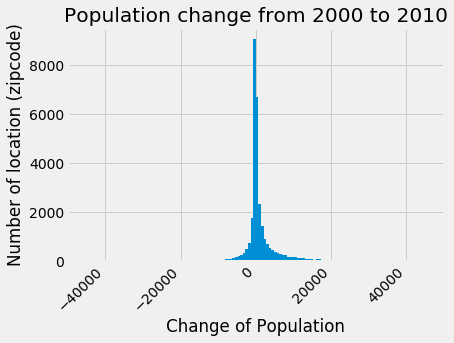

In [69]:
# Distribution of population change in the US
fig, ax = plt.subplots()

plt.hist(df_diff['diff'],500)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')

ax.set(xlim=[-50000, 50000], xlabel='Change of Population', ylabel='Number of location (zipcode)',
       title='Population change from 2000 to 2010')
plt.show()

**Population change by state**

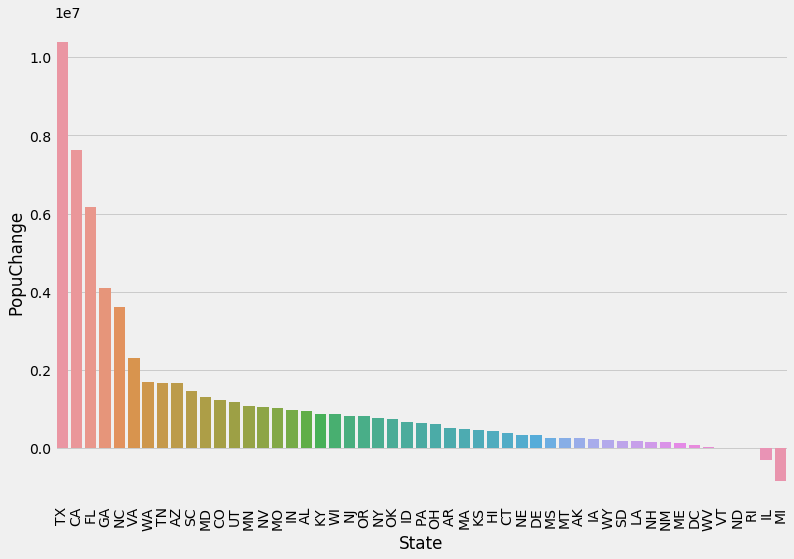

In [110]:
from pyzipcode import ZipCodeDatabase

zcdb = ZipCodeDatabase()
for i, row in df_diff.iterrows():
    #calculate distance
    try:
        zipcode = zcdb[row.zip]
        s = zipcode.state
        df_diff.set_value(i, 'State', s)
    except:
        pass

data = df_diff.groupby('State').sum()['diff'].sort_values(ascending = False)
df_data = data.to_frame()

df_data['State'] = df_data.index
df_data.columns = ['PopuChange', 'State']

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

g = sns.barplot(y='PopuChange', x='State', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.show()

**From this histogram, we learn that most of the locations remain the same population. Overall, there are more locations with an increase of population in the past 10 years.**

In [70]:
# Merge df_diff with df_zip
df_location = pd.merge(df_zip, df_diff, left_on='zip_code', right_on='zip', how='inner')
df_location.tail()

,job_description,job_title,location,organization,zip_code,state,city,distance_home,zip,diff
11189,RESPONSIBILITIES:Kforce has a client in Maderi...,Benefits Manager Job in Madeira,"Madeira, OH 45174",NaN,45174,OH,Madeira,2346.545087,45174,-93
11190,"As America""s Un-carrier, T-Mobile US, Inc. (NY...",Retail Sales Associate Job in Cincinnati,"Cincinnati, OH 45251",NaN,45251,OH,Cincinnati,2319.562867,45251,-4884
11191,Accounts Receivable Reconciliation Specialist ...,Accounts Receivable Reconciliation Specialist ...,"Cincinnati, OH 45251",NaN,45251,OH,Cincinnati,2319.562867,45251,-4884
11192,Job description:Press Operators - Flexo Folder...,Machine Operators and Helpers Job in Covington,"Covington, KY 41014",Printing and Publishing,41014,KY,Covington,2332.040514,41014,-1281
11193,Description:* Must be familiar with microsoft ...,Executive Assistant Job in Cincinnati,"Cincinnati, OH 45239",Transport and Storage - Materials,45239,OH,Cincinnati,2322.754287,45239,-2079


In [71]:
df_location = df_location[~df_location.distance_home.isnull()]

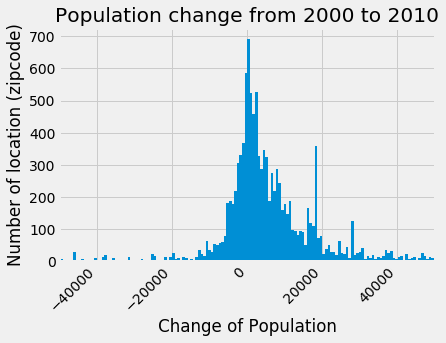

In [72]:
# Distribution of population change for the jobs in the dataset
fig, ax = plt.subplots()

plt.hist(df_location['diff'],500)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')

ax.set(xlim=[-50000, 50000], xlabel='Change of Population', ylabel='Number of location (zipcode)',
       title='Population change from 2000 to 2010')
plt.show()

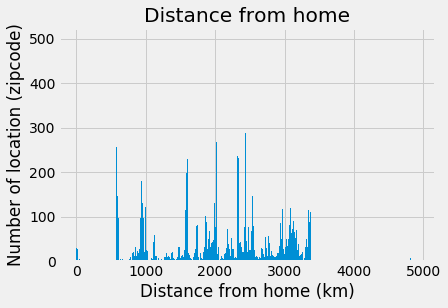

In [75]:
# Distribution of distance from home for the jobs in the dataset
fig, ax = plt.subplots()

plt.hist(df_location['distance_home'],500)
ax.set(xlabel='Distance from home (km)', ylabel='Number of location (zipcode)',
       title='Distance from home')
plt.show()

Here we define the location index (LI):

popu_diff = {[:, -10000):-2, [-10000, 0):-1, [0,10000):1, [10000,:]:0}

distance_home = {[0:1000):3, [1000,2000):2, [2000,3000):1, [3000,:]:0}

LI = A*popu_diff - B*distance_home. Let's say, A is 50% and B is 50%, they have equal weighs.

In [87]:
def popu_lim(diff):
    if int(diff) >= 10000:
        return 0
    elif int(diff) >= 0:
        return 1
    elif int(diff) >= -10000:
        return -1
    else:
        return -2

def distance_lim(dis):
    if dis >= 3000:
        return 0
    elif dis >= 2000:
        return 1
    elif dis >= 3000:
        return 2
    else:
        return 3

In [109]:
for index, row in df_location.iterrows():
    a = row
    df_location.set_value(index, 'LI', 0.5*popu_lim(row.tolist()[7])
                          +0.5*distance_lim(row.tolist()[9]))
df_location.head()

,job_description,job_title,location,organization,zip_code,state,city,distance_home,zip,diff,LI
0,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,78746,TX,Austin,1719.733992,78746,2715,1.0
1,Who we areAt the Texas County & District Retir...,CUSTOMER SERVICES REPRESENTATIVE Job in Austin,"Austin, TX 78746",Financial Services,78746,TX,Austin,1719.733992,78746,2715,1.0
2,Full-Time and PRN OpeningsBrookdale Westlake H...,Certified Nursing Assistant CNA Job in Austin,"Austin, TX 78746",Healthcare Services,78746,TX,Austin,1719.733992,78746,2715,1.0
3,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville,2877.625319,22611,3468,0.5
4,Aflac Insurance Sales AgentWhile a career in s...,Benefits Advisor Professional Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville,2877.625319,22611,3468,0.5


# Section 3: Culture and Industry

In this section, we're trying to judge the culture of a company by some key adjectives in the job descriptions, such as "flexible", "motivated", "innovative" and so on.

Also, we're trying to get the industry information of the company. Industry such as sports, media, software, communication, devices, music, non-profit and so on. This information may found from those nouns of the job description. For example, from the following case study, we may find "Journal", "reporter", "editor", "journalist", "trends" and so on may be a good represent of the industry of the company.

### Step 1: clean the text
First of all, let's clean the text in the job_description
1. Tokenize the sentence by separating them into words.
2. remove stopwords, symbols and make all the alphabet in lower case.
3. word stemming



In [ ]:
# the clean method saved in this function
def clean(tokens):
    # remove stopword
    fh = open('english.stop.txt','r')
    ls_stopword = []
    for item in fh:
        ls_stopword.append(item.rstrip('\n'))
    sample_removed = [x for x in tokens if x not in ls_stopword]

    # remove symbols
    ls_symbols = [',','.','[',']','<','>','%',' ', '•', 'null', 'x', '$', '+','’']
    sample_removed_s = [x for x in sample_removed if x not in ls_symbols]

    # lowercase all the tokens
    sample_removed_s = [x.lower() for x in sample_removed_s]

    # word stemming
#     stemmer = PorterStemmer()
#     sample_stemmed = [stemmer.stem(x) for x in sample_removed_s]
    
    return sample_removed_s

# Note: For example, 'motivated' after stemming is 'motiv'. 
# Seems PorterStemmer is a strong stemmer method. So, I decided not to use it.
stemmer = PorterStemmer()
stemmer.stem('motivated')

### Step 2: extract useful information (adjectives, nones) from the job description.
*A case study:*

In [ ]:
# Let's look at an example: 
sample = df.job_description[1]
sample

In [ ]:
# tokenize sentense
sentence = sample
tokens = nltk.word_tokenize(sentence)

# create tags for each word, this is done by using nltk 
tagged = nltk.pos_tag(tokens)

# extract adjectives and nouns
adj = [x[0] for x in tagged if x[1] == 'JJ']
noun = [x[0] for x in tagged if x[1] == 'NN' or x[1]=='NNS']

In [ ]:
# before cleaning process
adj

In [ ]:
# after the cleaning process
adj_c = clean(adj)
clean(adj)

**In the above list, I found the words: 'flexible', 'motivated', 'entrepreneurial', 'vibrant' are good indicator of the culture of the work. Other words: 'multimedia', 'online', 'digital', 'recent' are more indicating for the industry of the work.**

In [ ]:
# before cleaning process:
noun

In [ ]:
# after cleaning process
noun_c = clean(noun)
clean(noun)

In [ ]:
c_adj = Counter(adj)
c_adj.most_common(10)

In [ ]:
c_noun = Counter(noun)
c_noun.most_common(10)

**In the list of Noun, the following words: 'business', 'trends', 'reporting', 'news', 'reporter', 'journalist' are great indicator of the industry of this job**

It would be great if we can select those words from the list using some NLP tools. Let's try TF-IDF (term frequency inverse document frequency) first.

- https://planspace.org/20150524-tfidf_is_about_what_matters/
- https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
- https://www.youtube.com/watch?v=ZiKMIuYidY0&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=10

First, we need to create a simplified representation of the words in the job descriptions, so we can build mathematically models on them. One commonly used method is called bag-of-word, which represent words in the vocabulary by 0s and 1s. In our unsupervised 

In [ ]:
def token(sentence):
    tokens = nltk.word_tokenize(sentence)
    
    return tokens


def adj(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    adj = [x[0] for x in tagged if x[1] == 'JJ']
    
    return adj

def noun(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    noun = [x[0] for x in tagged if x[1] == 'NN' or x[1] == 'NNS']
    
    return noun

In [ ]:
/stop here, takes time to run the following 3 lines of code.

In [ ]:
df['token']=df['job_description'].apply(token)

In [ ]:
df['adj']=df['job_description'].apply(adj)

In [ ]:
df['noun']=df['job_description'].apply(noun)

Maybe continuous learning:

https://stackoverflow.com/questions/32759712/how-to-find-the-closest-word-to-a-vector-using-word2vec

In [ ]:
/stop here, takes time to run this.
# count the adj. and nouns in all of the jobs to figure out what't the most 
# commonly used words.
adj_all = []
noun_all = []

for i in tqdm(range(len(df))):
    sample = df.job_description[i]
    
    sentence = sample
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    adj = [x[0] for x in tagged if x[1] == 'JJ']
    noun = [x[0] for x in tagged if x[1] == 'NN' or x[1]=='NNS']
    
    df.set_value(i, 'adj', adj)
    df.set_value(i, 'noun', noun)
    
    adj_removed = clean(adj)
    noun_removed = clean(noun)
    
    for item_adj in adj_removed:
        adj_all.append(item_adj)
    for item_noun in noun_removed:
        noun_all.append(item_noun)
    sleep(0.001)

    
# count the frequency of words
c_noun_all = Counter(noun_all)
c_adj_all = Counter(adj_all)

# a list of the top 100 commonly used nouns
ls_top100_noun = [x[0] for x in c_noun_all.most_common(100)]

# a list of the top 100 commonly used adjs
ls_top100_adj = [x[0] for x in c_adj_all.most_common(100)]

## word2vec
To measure the distance between the job description and the answer of our questionnaire, we use pre-trained word and phrase vectors from [Google word2vec](https://code.google.com/archive/p/word2vec/). 

"This pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. "

In [ ]:
# save the processed DataFrame in to local files.
df.to_pickle('df')

In [ ]:
# load the pre-trainned model
word2vec_path = "GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# for example
print('example 1')
dog = word2vec['dog']
print(dog[:5])
print('')

# for example
print('example 2:')
print(word2vec.similarity('flexible', 'wonderful'))

In [ ]:
# one simple way of using it is get the average vector
def vec_avg(tokens):
    vec_list = []
    for word in tokens:
        try:
            vec_list.append(word2vec[word])
        except:
            pass
    
    return np.mean(vec_list, axis=0)

## Adjectives - culture

Given the key word: ['innovative','open','art','ai'], and try to find out the most related job from the dataset.

In [ ]:
# calculate the average vector of the all the tokens
df['adj_word2vec_avg']=df['adj'].apply(vec_avg)

# re-arrange the list of vector - prepare for PCA data format
ls = []
for i, row in df.iterrows():
    vec = row.adj_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        ls.append(vec)

# build visualization by fitting a PCA model
pca = PCA(n_components=2)
pca.fit(ls)
X = pca.transform(ls)

# Let's look at the location of the job from the questionnaire.
adj_q = ['innovative','open','art','ai']
vec_q = vec_avg(adj_q).tolist()
X_q = pca.transform([vec_q])

# make the scatter plot
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X[:,0], X[:,1],alpha=0.2, label = 'Jobs in the dataset')
ax.scatter(X_q[:,0], X_q[:,1], c="r", marker='x', label = 'Target job from questionnaire')
ax.set(xlabel='PCA-1', ylabel='PCA-2', title='Visualization of jobs')
legend = ax.legend(loc='upper right', fontsize='x-large')

In [ ]:
# the top20 cloest words in pre-trainned word2vec with the list from the questionnaire.
word2vec.most_similar(positive=[np.array(vec_q)], topn=20)

In [ ]:
# calculate the closest job description in the dataset
# first create a list of tuples
ls_tuple = []
for i, row in df.iterrows():
    vec = row.adj_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        dis = distance.euclidean(vec, vec_q)
        ls_tuple.append((i, dis))

# find out the index of the minimun distance
index_min = 0
dis_min = 2
for t in ls_tuple:
    index, dis = t
    if dis < dis_min:
        dis_min = dis
        index_min = index
index_min

# the top1 job in the dataset that matches the keywords in my questionnaire.
df.job_description[index_min]

**The out put job is a Software development job, which is a cool job. However, I may have concerns that I do not have enough experience with this kind of software development job. Thus, the next section, industry, gives us another aspect of the job we are looking for**

## Nouns - industry

Given my key word: ['healthcare', 'programming', 'research', 'analysis'], those are the keywords describing the industry I'm interested in as well as the skills I have. 

In [ ]:
# calculate the average vector of the all the tokens
df['noun_word2vec_avg']=df['noun'].apply(vec_avg)

# re-arrange the list of vector - prepare for PCA data format
ls = []
for i, row in df.iterrows():
    vec = row.noun_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        ls.append(vec)

# build visualization by fitting a PCA model
pca = PCA(n_components=2)
pca.fit(ls)
X = pca.transform(ls)

# Let's look at the location of the job from the questionnaire.
noun_q = ['healthcare', 'programming', 'research', 'analysis']
vec_q = vec_avg(noun_q).tolist()
X_q = pca.transform([vec_q])

# make the scatter plot
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X[:,0], X[:,1],alpha=0.2, label = 'Jobs in the dataset')
ax.scatter(X_q[:,0], X_q[:,1], c="r", marker='x', label = 'Target job from questionnaire')
ax.set(xlabel='PCA-1', ylabel='PCA-2', title='Visualization of jobs')
legend = ax.legend(loc='upper right', fontsize='x-large')

In [ ]:
# the top20 cloest words in pre-trainned word2vec with the list from the questionnaire.
word2vec.most_similar(positive=[np.array(vec_q)], topn=20)

In [ ]:
# calculate the closest job description in the dataset
# first create a list of tuples
ls_tuple = []
for i, row in df.iterrows():
    vec = row.noun_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        dis = distance.euclidean(vec, vec_q)
        ls_tuple.append((i, dis))

# find out the index of the minimun distance
index_min = 0
dis_min = 2
for t in ls_tuple:
    index, dis = t
    if dis < dis_min:
        dis_min = dis
        index_min = index
index_min

# the top1 job in the dataset that matches the keywords in my questionnaire.
df.job_description[index_min]

In [ ]:
string = df.job_description[index_min]
string = string.replace(u'\xa0', u' ')
string

In [ ]:
df.zip_code[index_min]

In [ ]:
df.zip_code[index_min]

**From the above analysis, the program gives me a job that is healthcare statistical programmer. I think it does matches what I'm interested in.**

# Combine all the factors together:

Let's say: 
- Location factor 20%
- Industry factor 40%
- Culture factor 40%

And we will calculate the most related job by using these weights. Location factor is a little bit tricky, since it's not in a vector format as the other factors.


In [ ]:
/ Other embedding emthod

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(ls_X) 
X_embedded.shape

In [ ]:
# bag_of_word method
# from gensim Quickstart

bow_corpus = [dictionary.doc2bow(text) for text in df_adj_ls]
bow_corpus

In [ ]:
# tf-idf modle
from gensim import models
# train the model
tfidf = models.TfidfModel(bow_corpus)
# transform the "system minors" string
xy = tfidf[dictionary.doc2bow("flexible art big local".lower().split())]

In [ ]:
x = [x[0] for x in xy]
y = [x[1] for x in xy]

In [ ]:
plt.scatter(x,y);